# STAT4012 Group Project
- The file is used to test the code for the project.  
- It should be written with **clear comments** and **explanations** on each sections of the code.  
- If there are some other modules that need to be imported or run in this file, you can use %load filename.py to load the code from the file. use %run filename.py to run the code from the file.  

In [65]:
# import libraries
# all the libraries are imported here but not below
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


In [66]:
data = pd.read_excel('../data/raw_data_adjusted.xlsx',
                     index_col=0).dropna(how='any')
data.sort_values(by='date', ascending=True, inplace=True)


## 1.Preprocessing

### 1.1 calculate 6th day's intraday return -> label

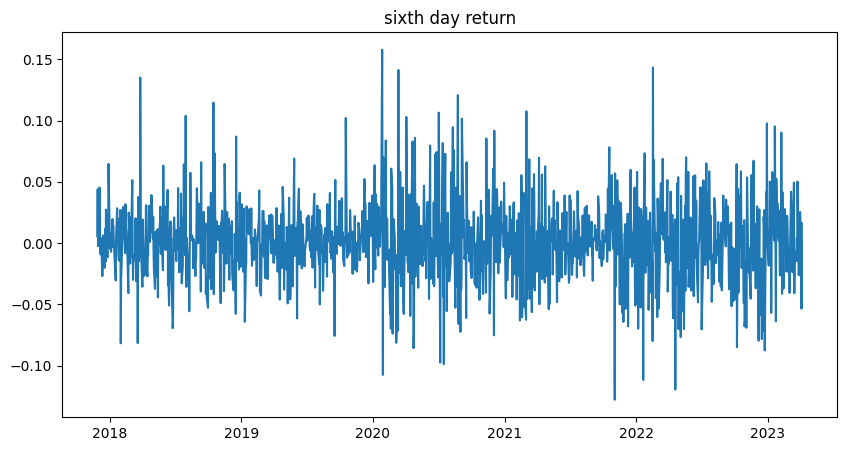

In [67]:
data['sixth_day_return'] = (
    (data['close'].shift(-5)-data['open'].shift(-5))/data['open'].shift(-5)).dropna(how='any')

# plot sixth day return
plt.figure(figsize=(10, 5))
plt.plot(data['sixth_day_return'])
plt.title('sixth day return')
plt.show()


### 1.2 mark golden cross point and death cross point

golden_cross    32.0
death_cross     31.0
dtype: float64


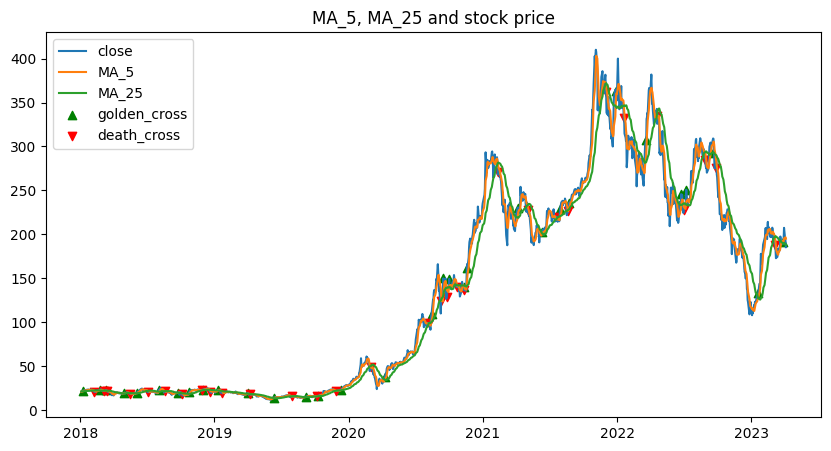

In [68]:
# calculate MA_5 and MA_25
data['MA_5'] = data['close'].rolling(5).mean()
data['MA_25'] = data['close'].rolling(25).mean()
data['diff'] = np.sign(data["MA_5"] - data["MA_25"])
data['signal'] = np.sign(data['diff'] - data['diff'].shift(1))
data['golden_cross'] = data['signal'].map({1: 1, 0: 0, -1: 0})
data['death_cross'] = data['signal'].map({-1: 1, 0: 0, 1: 0})
data = data.drop(columns=['diff', 'signal']).dropna(how='any')
print(data[['golden_cross', 'death_cross']].sum())

# plot MA_5 and MA_25 and stock price and golden cross and death cross as beautiful points, change a plot style
plt.figure(figsize=(10, 5))
plt.plot(data['close'], label='close')
plt.plot(data['MA_5'], label='MA_5')
plt.plot(data['MA_25'], label='MA_25')
plt.scatter(data[data['golden_cross'] == 1].index,
            data[data['golden_cross'] == 1]['close'], label='golden_cross', marker='^', color='green')
plt.scatter(data[data['death_cross'] == 1].index,
            data[data['death_cross'] == 1]['close'], label='death_cross', marker='v', color='red')
plt.title('MA_5, MA_25 and stock price')
plt.legend()
plt.show()

# plot for first 100 days
# plt.figure(figsize=(10, 5))
# plt.plot(data['close'][:100], label='close')
# plt.plot(data['MA_5'][:100], label='MA_5')
# plt.plot(data['MA_25'][:100], label='MA_25')
# plt.scatter(data[data['golden_cross'] == 1].index,
#             data[data['golden_cross'] == 1]['close'], label='golden_cross', marker='^', color='green')
# plt.scatter(data[data['death_cross'] == 1].index,
#             data[data['death_cross'] == 1]['close'], label='death_cross', marker='v', color='red')
# plt.title('MA_5, MA_25 and stock price for first 100 days')
# plt.legend()
# plt.show()

### 1.3 feature scaling: use normalization as extreme values are rare

In [ ]:
data = data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
print(data.head)


## 2.Feature Engineering

### PCA 

## 3. Build Model

### 3.0 hyperparameter tuning

### 3.1 Convolutional layer & MLP  （实验组）

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [ ]:
# choose a number of time steps
n_steps = 5
# convert into input/output
X, y = split_sequences(data.to_numpy(), n_steps)
print(X.shape, y.shape)


In [ ]:
# split for training set and testing set
X_train, X_test = X[:1000, :, :], X[1000:, :, :]
y_train, y_test = y[:1000], y[1000:]


In [ ]:
n_features = X.shape[2]
n_features


In [ ]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu',
          input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [ ]:
# fit model
model.fit(X_train, y_train, epochs=1000, verbose=1)


In [ ]:
# demonstrate prediction
y_pred = model.predict(X_test, verbose=1)


#### Model evaluation

In [ ]:
from keras import losses
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model.evaluate(X_test, y_test)


### 3.2 Attention-based LSTM model （实验组）
structure: data -> LSTM layer -> Attention layer -> Dense layer -> prediction

In [ ]:
from attention import Attention
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model


In [ ]:
time_steps = 5
input_dim = 20

# Define/compile the model.
model_input = Input(shape=(time_steps, input_dim))
x = LSTM(64, return_sequences=True)(model_input)
x = Attention(units=32)(x)
x = Dense(1)(x)
Attention_model = Model(model_input, x)
Attention_model.compile(loss='mae', optimizer='adam')
Attention_model.summary()


In [ ]:
# train.
Attention_model.fit(X_train, y_train, epochs=10)


In [ ]:
Attention_model.compile(loss='categorical_crossentropy',
                        optimizer='sgd',
                        metrics=['accuracy'])
Attention_model.evaluate(X_test, y_test)


### 3.3 Simple LSTM （对照组1）

In [ ]:
time_steps = 5
input_dim = 20

# Define/compile the model.
model_input = Input(shape=(time_steps, input_dim))
x = LSTM(64, return_sequences=True)(model_input)
x = Dense(1)(x)
LSTM_model = Model(model_input, x)
LSTM_model.compile(loss='mae', optimizer='adam')
LSTM_model.summary()


In [ ]:
# train.
LSTM_model.fit(X_train, y_train, epochs=10)


In [ ]:
LSTM_model.compile(loss='categorical_crossentropy',
                   optimizer='sgd',
                   metrics=['accuracy'])


需要evaluations

### 3.4 ARIMA model（对照组2）

In [ ]:
y_train = data['sixth_day_return'].iloc[:1000]
y_test = data['sixth_day_return'].iloc[1000:]


In [ ]:
# check stationary
plt.plot(y_train)   # looks good


In [ ]:
# ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(y_train)
print(result)  # p-value = 2e-30 -> stationary


In [ ]:
from pmdarima.arima import auto_arima

model = auto_arima(y_train, trace=True,
                   error_action='ignore', suppress_warnings=True)
print(model.aic())


In [ ]:
model.fit(y_train)

y_pred = model.predict(n_periods=len(y_test))
forecast = pd.DataFrame(
    y_pred.values, index=y_test.index, columns=['Prediction'])
print(forecast)


In [ ]:
# plot the predictions for validation set
plt.plot(y_train, label='Train', color='blue')
plt.plot(y_test, label='Valid', color='black')
plt.plot(forecast, label='Prediction', color='red')
plt.show()


In [ ]:
# evaluate the model


## 4. Model Evaluation

### 4.1 MSE, scores
### 4.2 Back-testing

In [ ]:
import backtrader as bt
import datetime


class Backtest(bt.Strategy):
    params = (("printlog", True), ("quantity", 20000))

    def log(self, txt, dt=None, doprint=False):
        """Logging function for strategy"""
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f"{dt.isoformat()}, {txt}")

    def __init__(self):
        self.dataopen = self.datas[0].open
        self.dataclose = self.datas[0].close
        self.order = 0
        self.open = 1

    def next(self):

        if self.order == 1:
            if self.open == 1:
                self.log('Open, %.2f' % self.dataopen[0])
                self.buy(size=self.params.quantity, exectype=bt.Order.Market)
                self.open = 0
            else:
                self.log('Close, %2f' % self.dataclose[0])
                self.close()
                self.open = 1

        if self.order == -1:
            if self.open == 1:
                self.log('Open, %.2f' % self.dataopen[0])
                self.buy(size=self.params.quantity, exectype=bt.Order.Market)
                self.open = 0
            else:
                self.log('Close, %2f' % self.dataclose[0])
                self.close()
                self.open = 1


if __name__ == "__main__":

    # Read data
    newdata = data.reset_index()
    array1 = np.repeat(newdata.values, 2, axis=0)
    for i in range(len(newdata.index)):
        array1[2*i+1][0] += datetime.timedelta(hours=14)
    newdata = pd.DataFrame(array1)
    newdata.columns = data.reset_index().columns
    newdata.set_index('date')
    newdata = newdata[['open', 'close', 'sixth_day_return']]
    newdata.head()

    # Add our strategy
    cerebro = bt.Cerebro()
    cerebro.addstrategy(IntraDayStrategy)

    # Add data
    data1 = bt.feeds.PandasData(dataname=newdata['2021-11-17':'2023-04-08'])
    cerebro.adddata(data1)

    # Run the strategy
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio,
                        riskfreerate=0.03, annualize=True, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
    result = cerebro.run()
    print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
    strat = result[0]

    # Analysis
    print("--------------- AnnualReturn -----------------")
    print(strat.analyzers.AnnualReturn.get_analysis())
    print("--------------- SharpeRatio -----------------")
    print(strat.analyzers.SharpeRatio.get_analysis())
    print("--------------- DrawDown -----------------")
    print(strat.analyzers.DrawDown.get_analysis())
    cerebro.plot()
